In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.cuda.is_available()

True

In [3]:
def preprocess_image(image):
    image = image.type(torch.float32)
    image = image / 255.
    return image

In [4]:
transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Lambda(lambda image: preprocess_image(image)),
    transforms.Resize((128, 128))
])

In [5]:
food101_ds = torchvision.datasets.Food101(root='./data/', download=False, transform=transform)

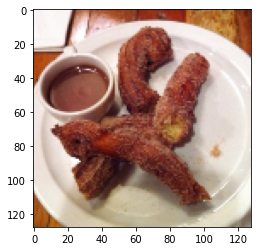

In [6]:
plt.imshow(food101_ds[0][0].permute(1, 2, 0))

In [10]:
food101_dl = torch.utils.data.DataLoader(food101_ds, batch_size=8, shuffle=True)

In [11]:
next_foods = next(iter(food101_dl))[0]

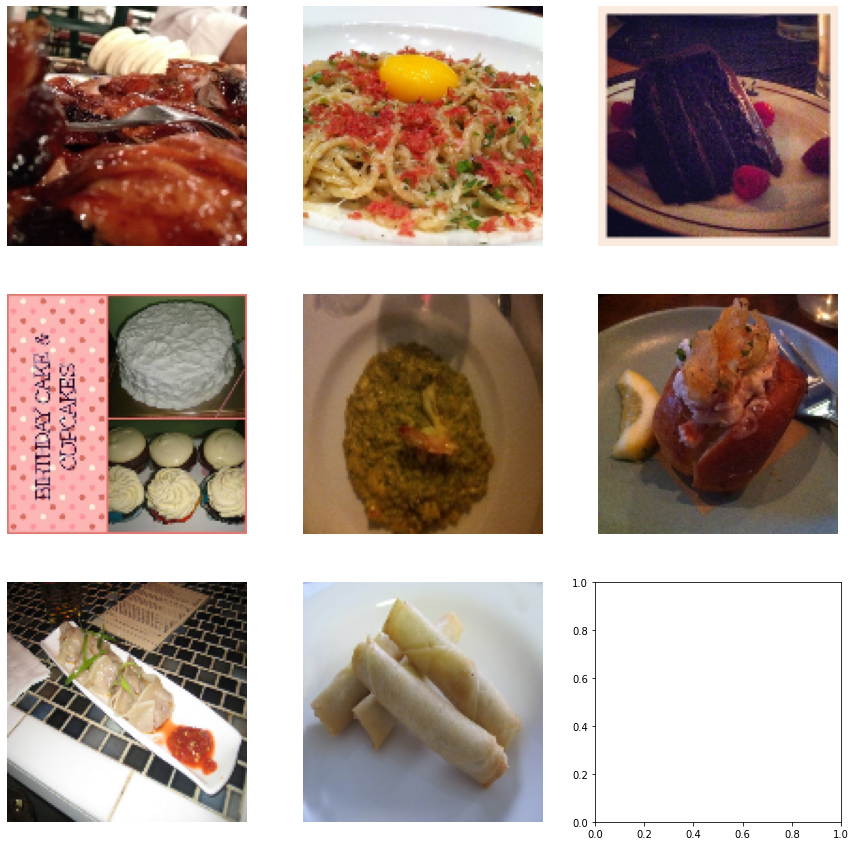

In [12]:
row = 0
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i in range(next_foods.shape[0]):
    if i % 3 == 0 and i != 0:
        row += 1
    ax[row, i % 3].imshow(next_foods[i].permute(1, 2, 0))
    ax[row, i % 3].axis('off')

In [13]:
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels):  
        super().__init__()
        
        self.res_block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channels, hidden_channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, out_channels, 3, padding=1),
        )
        
    def forward(self, x):
        return x + self.res_block(x)
    
class ResidualStack(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels, num_residuals):
        super().__init__()
        
        self.num_residuals = num_residuals
        self.res_stack = nn.Sequential()
        
        for _ in range(num_residuals):
            self.res_stack.append(Residual(in_channels, out_channels, hidden_channels))
        
    def forward(self, x):
        return self.res_stack(x)

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 256, 4, 2, padding=1)
        self.conv2 = nn.Conv2d(256, 256, 4, 2, padding=1)
        
        self.res_stack = ResidualStack(256, 256, 256, 3)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        res1 = self.res_stack(x)
        res2 = self.res_stack(x)
        res3 = self.res_stack(x)
        
        return res1 + res2 + res3
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_transpose1 = nn.ConvTranspose2d(256, 256, 4, 2, padding=1)
        self.conv_transpose2 = nn.ConvTranspose2d(256, 3, 4, 2, padding=1)
        
        self.res_stack = ResidualStack(256, 256, 256, 3)
    
    def forward(self, x):     
        res1 = self.res_stack(x)
        res2 = self.res_stack(x)
        res3 = self.res_stack(x)
        
        x = res1 + res2 + res3
        
        x = self.conv_transpose1(x)
        x = self.conv_transpose2(x)
        return x

In [14]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_weight):
        super().__init__()
        
        self._num_embeddings = num_embeddings
        self._embedding_dim = embedding_dim
        self._beta = commitment_weight
        
        self.codebook = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self.codebook.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        
    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x_flattened = x.view(-1, self._embedding_dim)
        
        euclid_distance = torch.sum(x_flattened ** 2, dim=1, keepdim=True) + \
                          torch.sum(self.codebook.weight ** 2, dim=1) - \
                          2 * torch.matmul(x_flattened, self.codebook.weight.t())
        
        encoding_indices = torch.argmin(euclid_distance, dim=1).unsqueeze(1)
        encodings = torch.zeros((euclid_distance.shape[0], self._num_embeddings), device=x.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        quantized = torch.matmul(encodings, self.codebook.weight).view(x.shape)
        
        e_loss = F.mse_loss(quantized.detach(), x)
        q_loss = F.mse_loss(quantized, x.detach())
        loss = e_loss + q_loss * self._beta
        
        quantized = x + (quantized - x).detach()
        
        avg_probs = torch.mean(encodings, 0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        quantized = quantized.permute(0, 3, 1, 2).contiguous()
        
        return loss, quantized, perplexity, encodings, encoding_indices

In [15]:
class VQVAE(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_weight):
        super().__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.vq = VectorQuantizer(num_embeddings, embedding_dim, commitment_weight)
        
    def forward(self, x):
        encoded = self.encoder(x)
        loss, quantized, perplexity, encodings, encoding_indices = self.vq(encoded)
        decoded = self.decoder(quantized)
        return loss, decoded, perplexity

In [16]:
torch.cuda.empty_cache() 

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vqvae = VQVAE(512, 64, 0.25).to(device)
optimizer = torch.optim.Adam(vqvae.parameters(), lr=1e-3, amsgrad=False)
# vqvae.load_state_dict(torch.load('vqvae_model_15000.pkl'))
# vqvae.eval()

In [18]:
train_reconstruction_errors = []
train_perplexities = []

for i in range(100_000):
    (data, _) = next(iter(food101_dl))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_reconstruction, perplexity = vqvae(data)
    reconstruction_error = F.mse_loss(data_reconstruction, data)
    loss = reconstruction_error + vq_loss
    loss.backward()

    optimizer.step()

    train_reconstruction_errors.append(reconstruction_error.item())
    train_perplexities.append(perplexity.item())

    if (i+1) % 100 == 0:
        print('{:d} iterations, recon_error : {:.3f}, perplexity: {:.3f}\r\n'.format(i+1, np.mean(train_reconstruction_errors[-100:]), np.mean(train_perplexities[-100:])))

100 iterations, recon_error : 0.071, perplexity: 10.853

200 iterations, recon_error : 0.016, perplexity: 23.732

300 iterations, recon_error : 0.014, perplexity: 51.812

400 iterations, recon_error : 0.011, perplexity: 83.137

500 iterations, recon_error : 0.008, perplexity: 104.088

600 iterations, recon_error : 4.654, perplexity: 70.892

700 iterations, recon_error : 0.797, perplexity: 5.040

800 iterations, recon_error : 0.093, perplexity: 19.913

900 iterations, recon_error : 0.046, perplexity: 34.216

1000 iterations, recon_error : 0.030, perplexity: 46.009

1100 iterations, recon_error : 0.026, perplexity: 60.572

1200 iterations, recon_error : 0.024, perplexity: 73.784

1300 iterations, recon_error : 0.025, perplexity: 85.906

1400 iterations, recon_error : 0.022, perplexity: 94.693

1500 iterations, recon_error : 0.020, perplexity: 101.059

1600 iterations, recon_error : 0.021, perplexity: 106.682

1700 iterations, recon_error : 0.057, perplexity: 105.540

1800 iterations, rec

14200 iterations, recon_error : 0.565, perplexity: 7.829

14300 iterations, recon_error : 0.289, perplexity: 8.428

14400 iterations, recon_error : 0.387, perplexity: 9.218

14500 iterations, recon_error : 0.450, perplexity: 9.985

14600 iterations, recon_error : 0.514, perplexity: 11.004

14700 iterations, recon_error : 0.535, perplexity: 11.683

14800 iterations, recon_error : 0.253, perplexity: 11.625

14900 iterations, recon_error : 0.165, perplexity: 11.369

15000 iterations, recon_error : 0.165, perplexity: 11.188

15100 iterations, recon_error : 0.210, perplexity: 11.214

15200 iterations, recon_error : 1.298, perplexity: 11.743

15300 iterations, recon_error : 1.231, perplexity: 13.180

15400 iterations, recon_error : 2.245, perplexity: 14.270

15500 iterations, recon_error : 0.626, perplexity: 15.467

15600 iterations, recon_error : 0.175, perplexity: 15.943

15700 iterations, recon_error : 0.183, perplexity: 16.406

15800 iterations, recon_error : 0.913, perplexity: 16.613

1

28100 iterations, recon_error : 0.043, perplexity: 29.005

28200 iterations, recon_error : 0.045, perplexity: 29.199

28300 iterations, recon_error : 0.044, perplexity: 29.750

28400 iterations, recon_error : 0.040, perplexity: 30.051

28500 iterations, recon_error : 0.038, perplexity: 30.849

28600 iterations, recon_error : 0.037, perplexity: 31.437

28700 iterations, recon_error : 0.035, perplexity: 32.535

28800 iterations, recon_error : 0.032, perplexity: 33.634

28900 iterations, recon_error : 0.029, perplexity: 34.208

29000 iterations, recon_error : 0.029, perplexity: 35.260

29100 iterations, recon_error : 0.028, perplexity: 35.381

29200 iterations, recon_error : 0.026, perplexity: 35.421

29300 iterations, recon_error : 0.028, perplexity: 36.284

29400 iterations, recon_error : 0.026, perplexity: 36.300

29500 iterations, recon_error : 0.025, perplexity: 36.431

29600 iterations, recon_error : 0.025, perplexity: 37.082

29700 iterations, recon_error : 0.024, perplexity: 38.14

42000 iterations, recon_error : 0.480, perplexity: 57.321

42100 iterations, recon_error : 0.422, perplexity: 58.355

42200 iterations, recon_error : 0.427, perplexity: 60.425

42300 iterations, recon_error : 0.321, perplexity: 61.380

42400 iterations, recon_error : 0.286, perplexity: 61.782

42500 iterations, recon_error : 0.271, perplexity: 63.194

42600 iterations, recon_error : 0.272, perplexity: 63.604

42700 iterations, recon_error : 0.188, perplexity: 64.464

42800 iterations, recon_error : 0.158, perplexity: 65.499

42900 iterations, recon_error : 0.155, perplexity: 68.080

43000 iterations, recon_error : 0.147, perplexity: 68.995

43100 iterations, recon_error : 0.119, perplexity: 69.673

43200 iterations, recon_error : 0.131, perplexity: 70.002

43300 iterations, recon_error : 0.122, perplexity: 71.950

43400 iterations, recon_error : 0.146, perplexity: 72.575

43500 iterations, recon_error : 0.116, perplexity: 74.316

43600 iterations, recon_error : 0.166, perplexity: 75.34

55900 iterations, recon_error : 0.004, perplexity: 100.047

56000 iterations, recon_error : 0.004, perplexity: 101.635

56100 iterations, recon_error : 0.003, perplexity: 107.352

56200 iterations, recon_error : 0.003, perplexity: 108.669

56300 iterations, recon_error : 0.003, perplexity: 112.715

56400 iterations, recon_error : 0.003, perplexity: 113.604

56500 iterations, recon_error : 0.003, perplexity: 114.156

56600 iterations, recon_error : 0.003, perplexity: 115.444

56700 iterations, recon_error : 0.003, perplexity: 113.422

56800 iterations, recon_error : 0.003, perplexity: 114.739

56900 iterations, recon_error : 0.004, perplexity: 113.003

57000 iterations, recon_error : 0.003, perplexity: 117.239

57100 iterations, recon_error : 1819.007, perplexity: 44.716

57200 iterations, recon_error : 71.404, perplexity: 8.732

57300 iterations, recon_error : 10.218, perplexity: 6.570

57400 iterations, recon_error : 1.354, perplexity: 6.572

57500 iterations, recon_error : 1.994, per

69700 iterations, recon_error : 0.005, perplexity: 145.292

69800 iterations, recon_error : 0.005, perplexity: 145.334

69900 iterations, recon_error : 0.005, perplexity: 146.988

70000 iterations, recon_error : 0.005, perplexity: 145.808

70100 iterations, recon_error : 0.005, perplexity: 147.884

70200 iterations, recon_error : 0.008, perplexity: 144.207

70300 iterations, recon_error : 0.005, perplexity: 142.841

70400 iterations, recon_error : 0.005, perplexity: 146.105

70500 iterations, recon_error : 0.005, perplexity: 146.523

70600 iterations, recon_error : 0.005, perplexity: 146.135

70700 iterations, recon_error : 0.008, perplexity: 141.585

70800 iterations, recon_error : 2543.952, perplexity: 41.281

70900 iterations, recon_error : 19.741, perplexity: 10.960

71000 iterations, recon_error : 1.805, perplexity: 10.486

71100 iterations, recon_error : 0.816, perplexity: 10.930

71200 iterations, recon_error : 0.609, perplexity: 10.845

71300 iterations, recon_error : 0.496, pe

83600 iterations, recon_error : 0.006, perplexity: 65.063

83700 iterations, recon_error : 0.005, perplexity: 64.865

83800 iterations, recon_error : 0.005, perplexity: 65.037

83900 iterations, recon_error : 0.006, perplexity: 65.721

84000 iterations, recon_error : 0.006, perplexity: 65.961

84100 iterations, recon_error : 0.005, perplexity: 66.133

84200 iterations, recon_error : 0.006, perplexity: 66.279

84300 iterations, recon_error : 0.006, perplexity: 66.117

84400 iterations, recon_error : 0.005, perplexity: 66.747

84500 iterations, recon_error : 0.009, perplexity: 66.190

84600 iterations, recon_error : 0.013, perplexity: 62.761

84700 iterations, recon_error : 0.005, perplexity: 64.864

84800 iterations, recon_error : 0.004, perplexity: 65.194

84900 iterations, recon_error : 0.005, perplexity: 66.937

85000 iterations, recon_error : 0.005, perplexity: 67.226

85100 iterations, recon_error : 0.005, perplexity: 67.643

85200 iterations, recon_error : 0.005, perplexity: 68.95

97500 iterations, recon_error : 0.006, perplexity: 58.915

97600 iterations, recon_error : 0.006, perplexity: 59.025

97700 iterations, recon_error : 0.006, perplexity: 59.607

97800 iterations, recon_error : 0.006, perplexity: 58.855

97900 iterations, recon_error : 0.007, perplexity: 59.222

98000 iterations, recon_error : 0.007, perplexity: 59.816

98100 iterations, recon_error : 0.007, perplexity: 59.873

98200 iterations, recon_error : 0.008, perplexity: 59.401

98300 iterations, recon_error : 0.007, perplexity: 59.672

98400 iterations, recon_error : 0.006, perplexity: 59.888

98500 iterations, recon_error : 0.006, perplexity: 60.270

98600 iterations, recon_error : 0.005, perplexity: 60.558

98700 iterations, recon_error : 0.006, perplexity: 61.776

98800 iterations, recon_error : 0.006, perplexity: 61.887

98900 iterations, recon_error : 0.005, perplexity: 62.021

99000 iterations, recon_error : 0.005, perplexity: 62.167

99100 iterations, recon_error : 0.005, perplexity: 62.52

In [19]:
torch.save(vqvae.state_dict(), 'vqvae_model_100000.pkl')

In [20]:
(data, _) = next(iter(food101_dl))

In [21]:
data = data.to(device)

encoded = vqvae.encoder(data)
_, quantized, _, _, _ = vqvae.vq(encoded)
reconstructions = vqvae.decoder(quantized)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


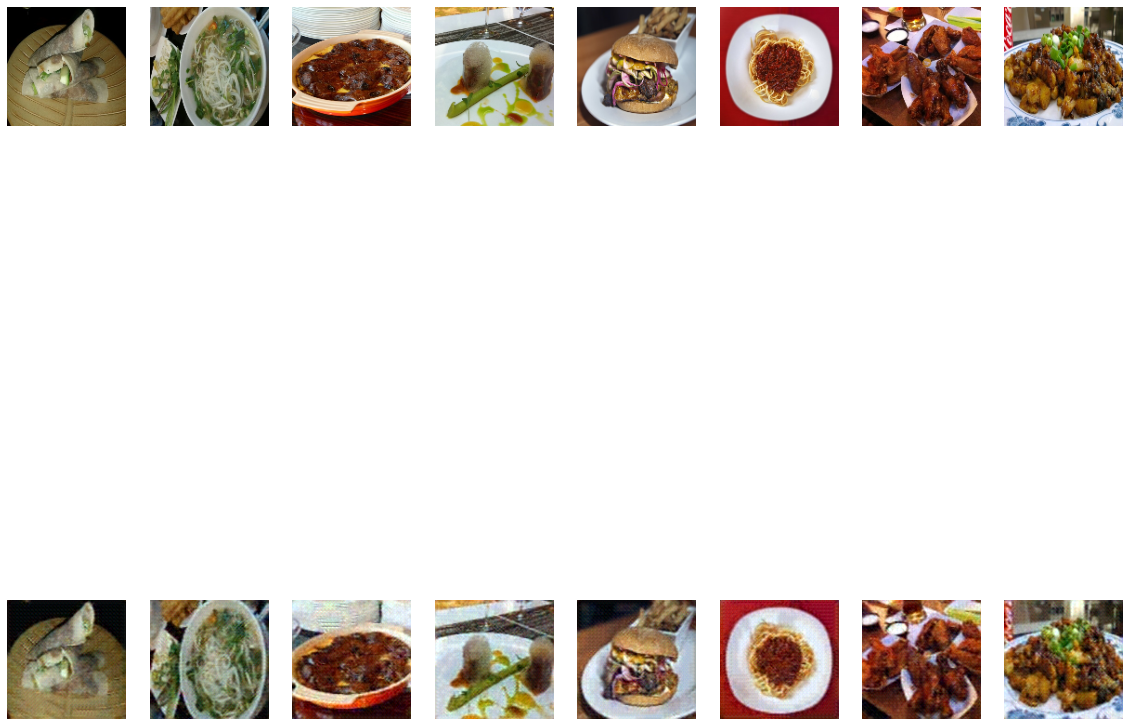

In [22]:
row = 0
fig, ax = plt.subplots(2, 8, figsize=(20, 20))

for i in range(16):
    if i % 8 == 0 and i != 0:
        row += 1
    if row == 0:
        ax[row, i % 8].imshow(data[i % 8].permute(1, 2, 0).cpu().detach().numpy())
    else:
        ax[row, i % 8].imshow(reconstructions[i % 8].permute(1, 2, 0).cpu().detach().numpy())
    ax[row, i % 8].axis('off')